### Imports, Directory and Path

In [1]:
import os
from os import path
import sys
import time

import numpy as np
import pandas as pd
from scipy.stats.mstats import zscore

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
BASE_DIR = "../AmesHousing/"
sys.path.append(path.abspath(BASE_DIR+'SupportModule/'))

import lookup_dir_names as DIR
import fnc_featureSelection as FS

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
scorer = make_scorer(mean_squared_error, False)

# RF/Modeling

In [32]:
def featureNorm(Features):
    featnorm = StandardScaler()
    normFeatures = featnorm.fit_transform(Features)
    return normFeatures
    
def splitTrainTest(X, Y, split_size=0.3, seed=np.random.seed()):
    Xtrn, Xtest, Ytrn, Ytest = train_test_split(X, Y, test_size=split_size, random_state=seed)
    return Xtrn, Xtest, Ytrn, Ytest

def applyRandomForest(Xtrn, Xtest, Ytrn, Ytest, n_est=100):
    rf = RandomForestRegressor(n_estimators=n_est, criterion='mse', max_depth=None, min_samples_split=10, 
                          min_samples_leaf=2, min_weight_fraction_leaf=0.0, max_features='auto', 
                          max_leaf_nodes=None, bootstrap=True, n_jobs=-1)

    rf.fit(Xtrn, Ytrn)
    feature_importance = rf.feature_importances_
    
    Ypred = rf.predict(Xtest)
    score = r2_score(Ytest, Ypred, sample_weight=None, multioutput='uniform_average')
    
    
    return feature_importance, score, Ypred

### Feature importance

**Numerical training data**

In [18]:
trn = pd.read_csv(DIR.DATA_IN+"train.csv")
trn_num = FS.combineFeatures_02(trn) 
trn_num.columns.values

array(['LotArea', 'LotFrontage', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'GarageArea', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'Fireplaces', 'YearBuilt', 'YearRemodAdd'], dtype=object)

In [19]:
clf = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=10, 
                          min_samples_leaf=2, min_weight_fraction_leaf=0.0, max_features='auto', 
                          max_leaf_nodes=None, bootstrap=True, n_jobs=-1)

clf.fit(trn_num, trn['SalePrice'].apply(np.log))
feature_importance = clf.feature_importances_

# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(feature_importance, index = trn_num.columns).sort_values(ascending=False)
coef

GrLivArea        0.344724
YearBuilt        0.253801
GarageCars       0.087971
TotalBsmtSF      0.075379
GarageArea       0.049241
1stFlrSF         0.031602
YearRemodAdd     0.031101
Fireplaces       0.028072
BsmtFinSF1       0.025000
LotArea          0.024417
BsmtUnfSF        0.010282
2ndFlrSF         0.009958
LotFrontage      0.007282
OpenPorchSF      0.006540
WoodDeckSF       0.003991
HalfBath         0.002405
EnclosedPorch    0.002333
BsmtFullBath     0.001583
BsmtFinSF2       0.001511
FullBath         0.001346
ScreenPorch      0.000760
BsmtHalfBath     0.000246
LowQualFinSF     0.000215
3SsnPorch        0.000151
PoolArea         0.000089
dtype: float64

**Numerical features combined to create new features**

In [22]:
trn = pd.read_csv(DIR.DATA_IN+"train.csv")
num_df, ctg_df, dummy_df = FS.combineFeatures_01(trn)
num_df.columns.values

array(['TotLotSF', 'TotFlrSF', 'TotalBsmtSF', 'TotNumBath', 'GarageArea',
       'PorchArea', 'PoolArea'], dtype=object)

In [23]:
clf = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=10, 
                          min_samples_leaf=2, min_weight_fraction_leaf=0.0, max_features='auto', 
                          max_leaf_nodes=None, bootstrap=True, n_jobs=-1)

clf.fit(num_df, trn['SalePrice'].apply(np.log))
feature_importance = clf.feature_importances_

# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(feature_importance, index = num_df.columns).sort_values(ascending=False)
coef

TotFlrSF       0.486285
GarageArea     0.199307
TotalBsmtSF    0.176208
TotNumBath     0.073506
TotLotSF       0.033766
PorchArea      0.030915
PoolArea       0.000014
dtype: float64

### RF

### Training data 
Select features and perform feature engineering according to `fnc_featureSelection`

In [24]:
trn = pd.read_csv(DIR.DATA_IN+"train.csv")
num_df, ctg_df, dummy_df = FS.combineFeatures_01(trn)
target_df = trn['SalePrice']

print(num_df.shape)
print(ctg_df.shape)
print(dummy_df.shape)
print(target_df.shape)

(1460, 7)
(1460, 5)
(1460, 54)
(1460,)


**Column names**

In [25]:
trn.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'Pav

In [26]:
num_df.columns.values

array(['TotLotSF', 'TotFlrSF', 'TotalBsmtSF', 'TotNumBath', 'GarageArea',
       'PorchArea', 'PoolArea'], dtype=object)

In [27]:
ctg_df.columns.values

array(['Year', 'isGarage', 'isFireplace', 'isPorch', 'isPool'], dtype=object)

In [28]:
dummy_df.columns.values

array(['GarageCars_0', 'GarageCars_1', 'GarageCars_2', 'GarageCars_3',
       'GarageCars_4', 'OverallQual_1', 'OverallQual_10', 'OverallQual_2',
       'OverallQual_3', 'OverallQual_4', 'OverallQual_5', 'OverallQual_6',
       'OverallQual_7', 'OverallQual_8', 'OverallQual_9', 'OverallCond_1',
       'OverallCond_2', 'OverallCond_3', 'OverallCond_4', 'OverallCond_5',
       'OverallCond_6', 'OverallCond_7', 'OverallCond_8', 'OverallCond_9',
       'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhoo

### 1

In [34]:
df = pd.concat((num_df, ctg_df, dummy_df), axis=1)
# df['OverallQual'] =  trn['OverallQual']
# df['OverallCond'] = trn['OverallCond']
# df['Neighborhood'] = trn['Neighborhood']

In [35]:
X = df
Y_log = trn['SalePrice'].apply(np.log)
Xtrn, Xtest, Ytrn, Ytest = splitTrainTest(X, Y_log, split_size=0.3)

feature_importance, score, Ypred =  applyRandomForest(Xtrn, Xtest, Ytrn, Ytest,  n_est=100)

print(score)

0.877967057967


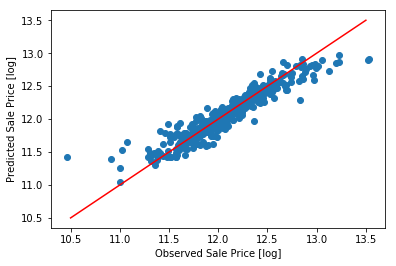

In [36]:
plt.scatter(Ytest, Ypred)
plt.xlabel("Observed Sale Price [log]")
plt.ylabel("Predicted Sale Price [log]")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

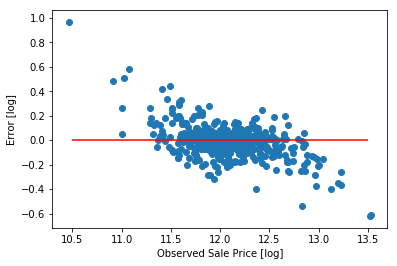

In [37]:
plt.scatter(Ytest, Ypred-Ytest)
plt.xlabel("Observed Sale Price [log]")
plt.ylabel("Error [log]")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()